# Initialization
using Python 3.11.9, Tensorflow 2.18 and Keras 3.5

In [ ]:
!pip uninstall -y tensorflow keras
!pip install tensorflow keras-cv keras-nlp keras pandas numpy matplotlib seaborn scikit-learn

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00


In [ ]:
# conda install pandas numpy matplotlib seaborn scikit-learn
# pip install tensorflow keras-cv keras-nlp keras
import time
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras_core.models import Sequential
from keras_core.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM, MaxPooling1D, Input
from keras_core.preprocessing.sequence import pad_sequences
from keras_core.utils import to_categorical
from keras_core.callbacks import EarlyStopping

Using TensorFlow backend


# Define functions

In [ ]:
# Convert sequences back to text for Naive Bayes
def sequences_to_texts(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence]) for sequence in sequences]

# Define helper functions for metrics and visualization
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add class-wise metrics
    class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print("\nClass-wise metrics:")
    for i, (p, r, f) in enumerate(zip(class_precision, class_recall, class_f1)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add class distribution information
    class_distribution = np.sum(cm, axis=1)
    plt.text(1.5, -0.5, f"Class Distribution: {class_distribution}", fontsize=10, ha='right', va='center')

    plt.show()

def plot_roc_curve(y_true, y_pred, model_name):
    # Binarize the output
    classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    # Check if y_pred is already probability estimates
    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        # If not, convert to probability estimates
        y_pred_bin = label_binarize(y_pred, classes=classes)
        y_score = y_pred_bin
    else:
        y_score = y_pred

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def analyze_predictions(y_true, y_pred, model_name):
    print(f"\nAnalysis for {model_name}:")

    # Class distribution in true labels
    unique, counts = np.unique(y_true, return_counts=True)
    print("Class distribution in true labels:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Class distribution in predictions
    unique, counts = np.unique(y_pred, return_counts=True)
    print("\nClass distribution in predictions:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Check for classes not predicted
    true_classes = set(y_true)
    pred_classes = set(y_pred)
    not_predicted = true_classes - pred_classes
    if not_predicted:
        print(f"\nClasses not predicted by the model: {not_predicted}")

def create_train_test_split(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Pad sequences
    max_length = 500  # or whatever your max_length is
    X_train_padded = pad_sequences(X_train, maxlen=max_length)
    X_test_padded = pad_sequences(X_test, maxlen=max_length)

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    return X_train_padded, X_test_padded, y_train_cat, y_test_cat, y_train, y_test


# Function to load GloVe embeddings
def load_glove_embeddings(word_index, embedding_dim):
    embeddings_index = {}
    with open(f'glove.6B.{embedding_dim}d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    num_words = min(len(word_index) + 1, 10000)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


# Load our python library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/phd

Mounted at /content/drive
/content/drive/MyDrive/phd


In [ ]:
#drive.flush_and_unmount(0)

In [ ]:
from bgg import load_data, get_word_index


# Load the data

In [ ]:
# Load the full dataset
X, y = load_data(num_words=10000, maxlen=500)
word_index = get_word_index()

num_words = min(10000, len(word_index) + 1)
print(f"Number of words in word_index: {len(word_index)}")
print(f"Shape of y:{y.shape}")
print(f"Unique classes in y: {np.unique(y)}")
print(f"Example of first few labels: {y[:10]}")

Number of words in word_index: 177257
Shape of y:(903916,)
Unique classes in y: [0 1 2]
Example of first few labels: [2 1 2 2 2 2 2 2 0 0]


Overall Dataset Sentiment Distribution:


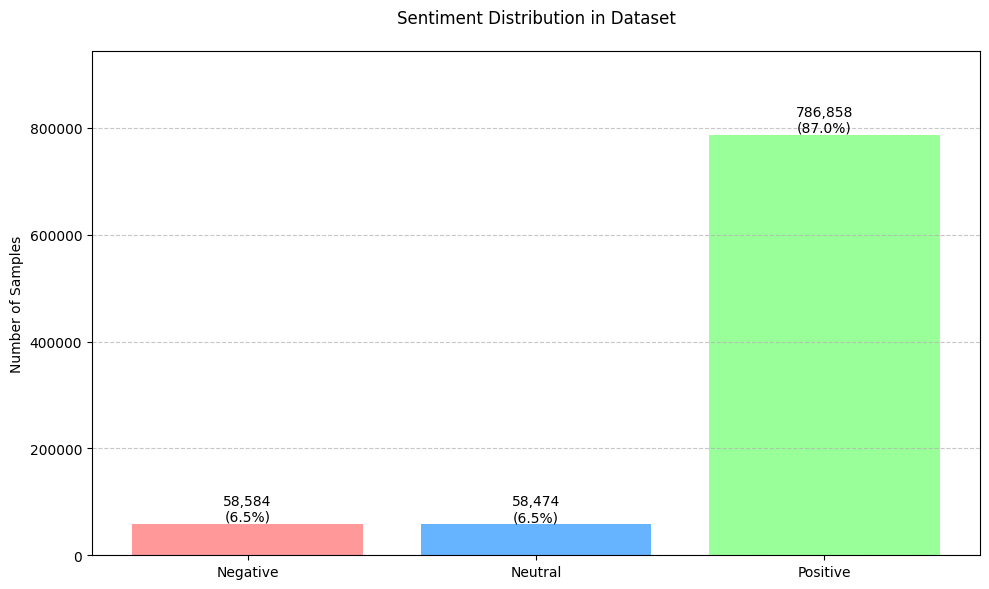


Detailed Sentiment Distribution Statistics:
--------------------------------------------------
Sentiment  Count        Percentage
--------------------------------------------------
Negative   58,584       6.48      %
Neutral    58,474       6.47      %
Positive   786,858      87.05     %
--------------------------------------------------
Total: 903,916 samples

Class Imbalance Metrics:
Imbalance Ratio (Positive:Neutral): 13.46:1
Most frequent sentiment: Positive (786,858 samples)
Least frequent sentiment: Neutral (58,474 samples)


In [ ]:
def analyze_sentiment_distribution(y, title="Sentiment Distribution in Dataset"):
    """
    Create a single comprehensive bar chart showing sentiment distribution with both counts and percentages
    """
    # Define sentiment labels
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    # Calculate distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_percentages = (class_counts / total_samples) * 100

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
    bars = plt.bar(sentiment_labels, class_counts, color=colors)

    # Primary y-axis (counts)
    plt.ylabel('Number of Samples', color='black')
    plt.tick_params(axis='y', labelcolor='black')

    # Add count and percentage labels on top of bars
    for bar, count, percentage in zip(bars, class_counts, class_percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count):,}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Adjust y-axis limits to prevent cutting off labels
    plt.margins(y=0.2)  # Add 20% padding to the top

    # Customize the plot
    plt.title(title, pad=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed statistics
    print("\nDetailed Sentiment Distribution Statistics:")
    print("-" * 50)
    print(f"{'Sentiment':<10} {'Count':<12} {'Percentage':<10}")
    print("-" * 50)
    for label, count, pct in zip(sentiment_labels, class_counts, class_percentages):
        print(f"{label:<10} {count:<12,} {pct:<10.2f}%")
    print("-" * 50)
    print(f"Total: {total_samples:,} samples")

    # Calculate and print imbalance metrics
    max_count = max(class_counts)
    min_count = min(class_counts)
    imbalance_ratio = max_count / min_count
    majority_sentiment = sentiment_labels[np.argmax(class_counts)]
    minority_sentiment = sentiment_labels[np.argmin(class_counts)]

    print(f"\nClass Imbalance Metrics:")
    print(f"Imbalance Ratio ({majority_sentiment}:{minority_sentiment}): {imbalance_ratio:.2f}:1")
    print(f"Most frequent sentiment: {majority_sentiment} ({max_count:,} samples)")
    print(f"Least frequent sentiment: {minority_sentiment} ({min_count:,} samples)")

# Usage
print("Overall Dataset Sentiment Distribution:")
analyze_sentiment_distribution(y)

# Naive Bayes implementation
This section implements the Naive Bayes model, makes predictions, and generates all the required metrics and visualizations. It uses the helper functions defined in the previous section for consistency across all models.

N-gram range: (1, 1)
Accuracy: 0.8566
Training Time: 0.16 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36     14574
           1       0.22      0.11      0.15     14556
           2       0.91      0.95      0.93    196849

    accuracy                           0.86    225979
   macro avg       0.51      0.46      0.48    225979
weighted avg       0.83      0.86      0.84    225979

--------------------------------------------------
N-gram range: (1, 2)
Accuracy: 0.8753
Training Time: 0.80 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.08      0.14     14574
           1       0.44      0.01      0.01     14556
           2       0.88      1.00      0.93    196849

    accuracy                           0.88    225979
   macro avg       0.67      0.36      0.36    225979
weighted avg       0.84      0.88      0.82    225979

-------

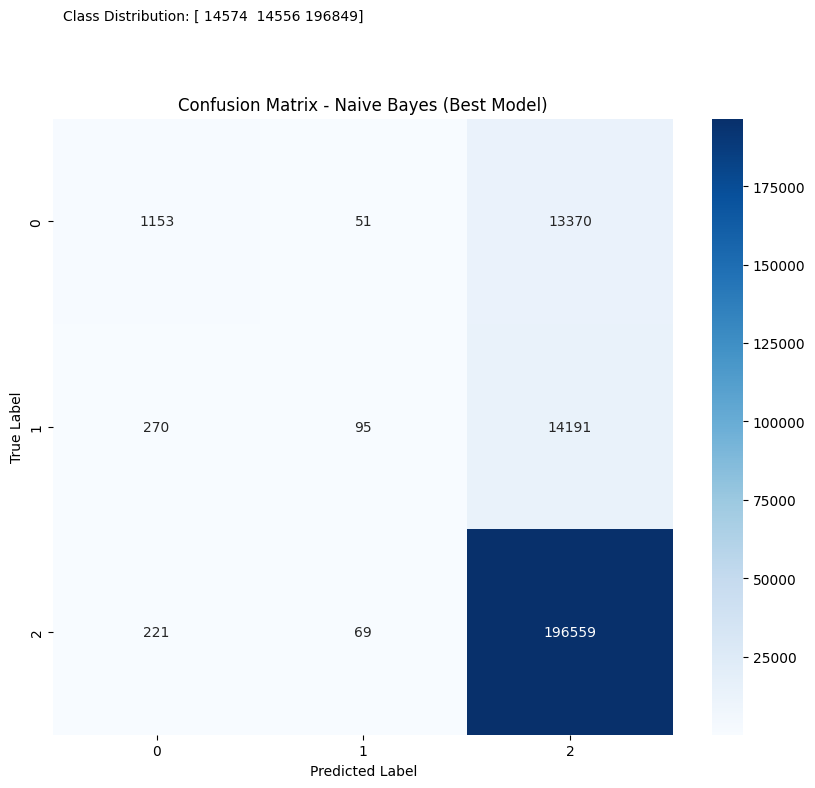

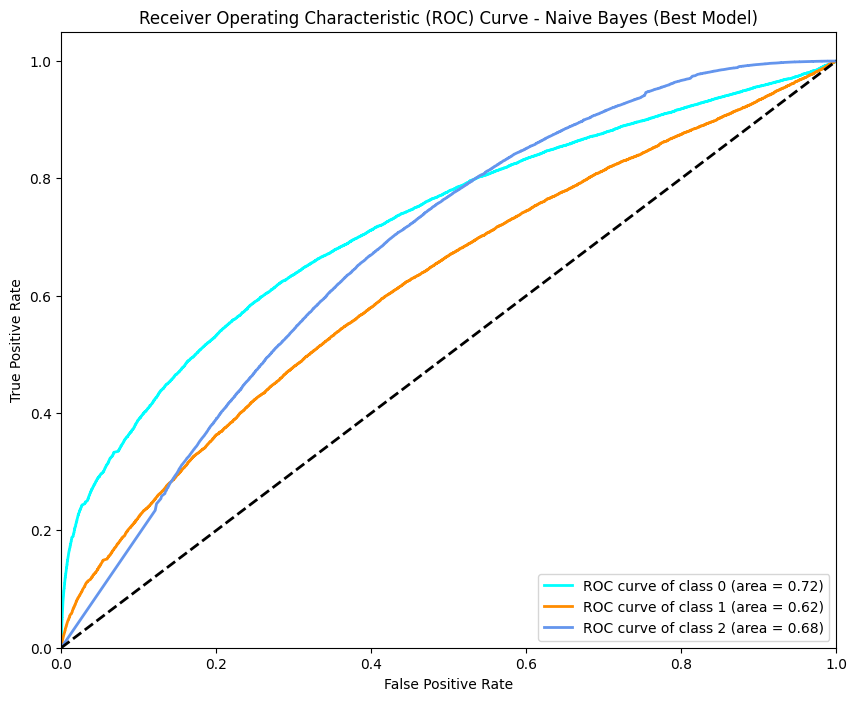


Classification Report - Naive Bayes (Best Model):
              precision    recall  f1-score   support

           0       0.70      0.08      0.14     14574
           1       0.44      0.01      0.01     14556
           2       0.88      1.00      0.93    196849

    accuracy                           0.88    225979
   macro avg       0.67      0.36      0.36    225979
weighted avg       0.84      0.88      0.82    225979


Analysis for Naive Bayes (Best Model):
Class distribution in true labels:
Class 0: 14574
Class 1: 14556
Class 2: 196849

Class distribution in predictions:
Class 0: 1644
Class 1: 215
Class 2: 224120


In [ ]:
# Function to train and evaluate Naive Bayes model with different n-gram ranges
def evaluate_nb_with_ngrams(X_train, y_train, X_test, y_test, ngram_range):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    start_time = time.time()

    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)

    y_pred = nb_model.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, y_pred)
    train_time = time.time() - start_time

    print(f"N-gram range: {ngram_range}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 50)

    return nb_model, vectorizer, y_pred, nb_model.predict_proba(X_test_vectorized), train_time


# Create a specific split for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert sequences back to text for Naive Bayes
def sequences_to_text(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0]) for sequence in sequences]

X_train_nb_text = sequences_to_text(X_train_nb, word_index)
X_test_nb_text = sequences_to_text(X_test_nb, word_index)

ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)]
best_model = None
best_accuracy = 0
best_vectorizer = None
best_predictions = None
best_probabilities = None

for ngram_range in ngram_ranges:
    model, vectorizer, predictions, probabilities, train_time = evaluate_nb_with_ngrams(X_train_nb_text, y_train_nb, X_test_nb_text, y_test_nb, ngram_range)
    accuracy = accuracy_score(y_test_nb, predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_vectorizer = vectorizer
        best_predictions = predictions
        best_probabilities = probabilities
        best_train_time = train_time

print(f"Best N-gram range: {best_vectorizer.ngram_range}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Use the best model for further analysis
y_pred_nb = best_predictions
y_pred_proba_nb = best_probabilities

# Print metrics
print_metrics(y_test_nb, y_pred_nb, "Naive Bayes (Best Model)")

# Plot confusion matrix
plot_confusion_matrix(y_test_nb, y_pred_nb, "Naive Bayes (Best Model)")

# Plot ROC curve
plot_roc_curve(y_test_nb, y_pred_proba_nb, "Naive Bayes (Best Model)")

# Print classification report
print("\nClassification Report - Naive Bayes (Best Model):")
print(classification_report(y_test_nb, y_pred_nb, zero_division=0))

# Analyze predictions
analyze_predictions(y_test_nb, y_pred_nb, "Naive Bayes (Best Model)")

# Store results for later comparison
nb_results_dict = {
    'model': best_model,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'y_true': y_test_nb,
    'y_pred': y_pred_nb,
    'y_pred_proba': y_pred_proba_nb
}

# CNN
This section defines, trains, and evaluates the CNN model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


Training CNN with embedding dimension: 100
Epoch 1/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.8736 - loss: 0.4142 - val_accuracy: 0.8807 - val_loss: 0.3660
Epoch 2/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.8801 - loss: 0.3602 - val_accuracy: 0.8801 - val_loss: 0.3593
Epoch 3/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8837 - loss: 0.3426 - val_accuracy: 0.8819 - val_loss: 0.3584
Epoch 4/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8870 - loss: 0.3254 - val_accuracy: 0.8817 - val_loss: 0.3611
Epoch 5/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8906 - loss: 0.3047 - val_accuracy: 0.8794 - val_loss: 0.3732
Test Accuracy: 0.8794
5650/5650 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Training CNN with embedding dimension: 200
Epoch 1/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.8725 - loss: 0.4097 - val_accuracy: 0.8811 - val_loss: 0.3599
Epoch 2/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step

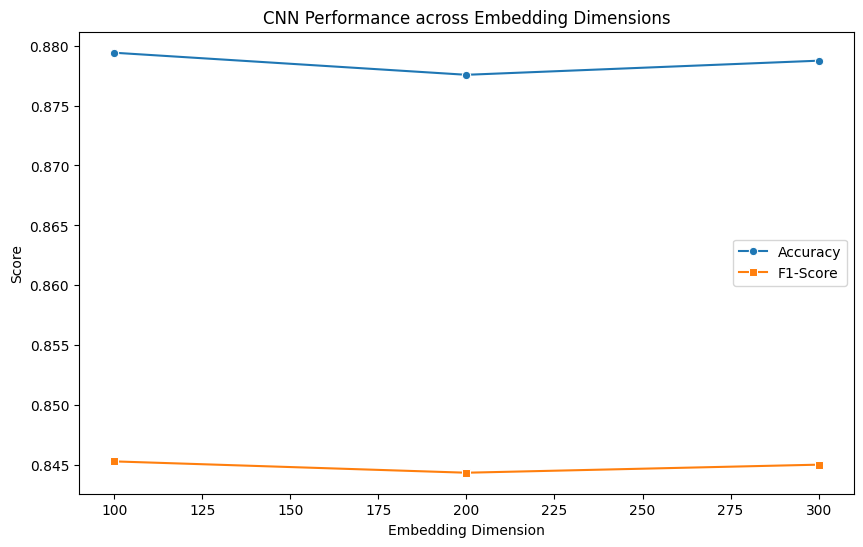

CNN Variation Results:
 Embedding Dim  Accuracy  F1-Score  AUC-ROC  Training Time
           100  0.879409  0.845315 0.846969     263.889919
           200  0.877567  0.844370 0.840113     267.821084
           300  0.878745  0.845042 0.845576     291.481699

Best CNN Configuration: Embedding Dim = 100.0
Best Accuracy: 0.8794
Best F1-Score: 0.8453

Best embedding dimension: 100
Best Accuracy: 0.8794
5650/5650 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Metrics for CNN (Embedding Dim: 100):
Accuracy: 0.8794
Precision: 0.8152
Recall: 0.8794
F1 Score: 0.8453

Class-wise metrics:
Class 0: Precision: 0.4809, Recall: 0.3721, F1: 0.4196
Class 1: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2: Precision: 0.9003, Recall: 0.9820, F1: 0.9394

Confusion Matrix:
[[  4330      0   7306]
 [  1845      0   9821]
 [  2829      0 154653]]


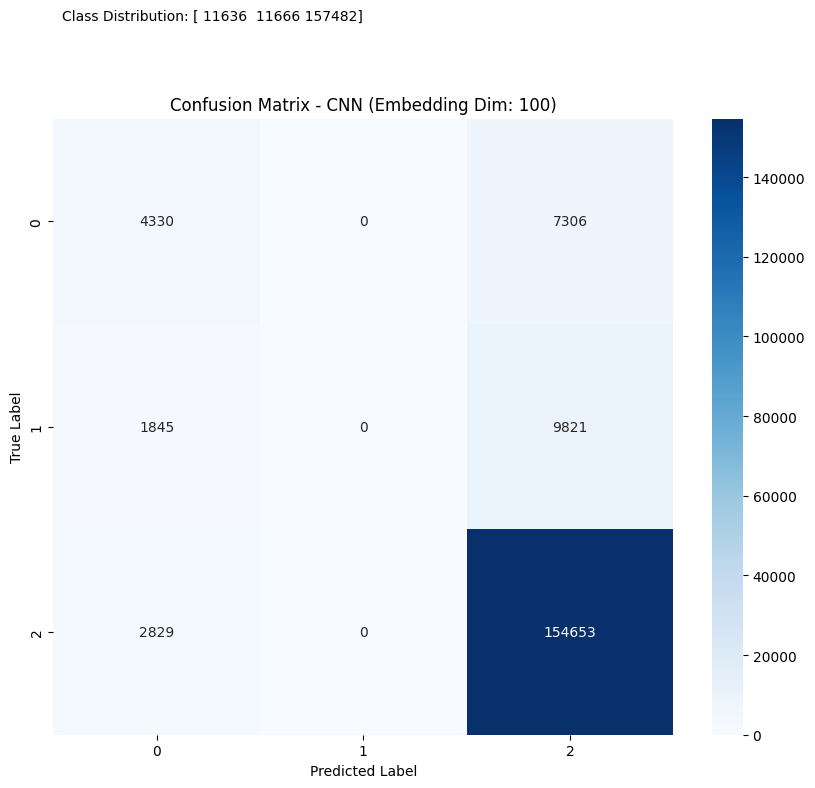

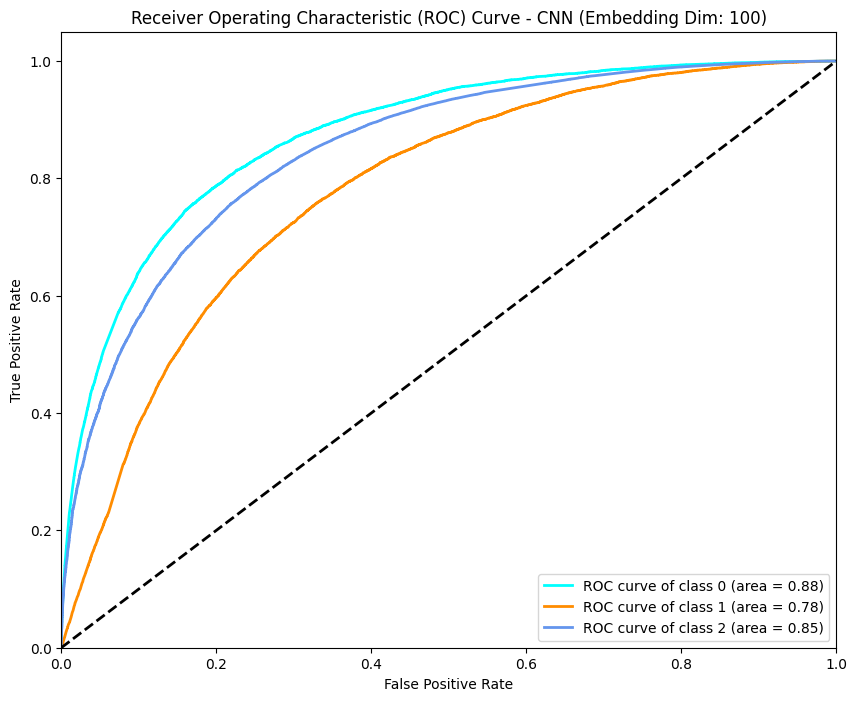


Classification Report - CNN (Embedding Dim: 100):
              precision    recall  f1-score   support

           0       0.48      0.37      0.42     11636
           1       0.00      0.00      0.00     11666
           2       0.90      0.98      0.94    157482

    accuracy                           0.88    180784
   macro avg       0.46      0.45      0.45    180784
weighted avg       0.82      0.88      0.85    180784



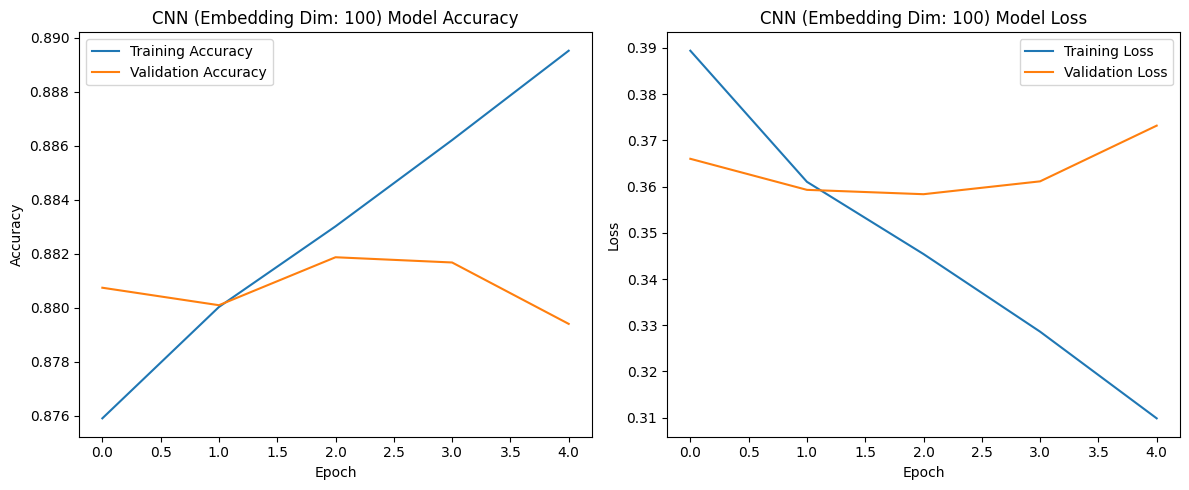


Analysis for CNN (Embedding Dim: 100):
Class distribution in true labels:
Class 0: 11636
Class 1: 11666
Class 2: 157482

Class distribution in predictions:
Class 0: 9004
Class 2: 171780

Classes not predicted by the model: {1}


In [ ]:
def create_and_train_cnn(embedding_dim, num_words, max_length, X_train, y_train, X_test, y_test, embedding_matrix):
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        GlobalMaxPooling1D(name='global_max_pooling1d'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    return model, history, train_time

def compare_cnn_variations(cnn_results):
    cnn_df = pd.DataFrame(cnn_results, columns=['Embedding Dim', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])
    # Replace infinity values with NaN
    cnn_df = cnn_df.replace([np.inf, -np.inf], np.nan)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='F1-Score', marker='s', label='F1-Score')
    plt.title('CNN Performance across Embedding Dimensions')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("CNN Variation Results:")
    print(cnn_df.to_string(index=False))

    # Determine best configuration
    best_cnn = cnn_df.loc[cnn_df['Accuracy'].idxmax()]
    print(f"\nBest CNN Configuration: Embedding Dim = {best_cnn['Embedding Dim']}")
    print(f"Best Accuracy: {best_cnn['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_cnn['F1-Score']:.4f}")

# Create a specific split for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Pad sequences
max_length = 500
X_train_cnn_padded = pad_sequences(X_train_cnn, maxlen=max_length)
X_test_cnn_padded = pad_sequences(X_test_cnn, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_cnn))
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=num_classes)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes=num_classes)

# Test different embedding dimensions
embedding_dims = [100, 200, 300]
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

best_model = None
best_accuracy = 0
best_history = None
best_dim = None

cnn_results = []

for dim in embedding_dims:
    print(f"\nTraining CNN with embedding dimension: {dim}")

    # Load GloVe embeddings for the current dimension
    embedding_matrix = load_glove_embeddings(word_index, dim)

    model, history, train_time = create_and_train_cnn(dim, num_words, max_length, X_train_cnn_padded, y_train_cnn_cat, X_test_cnn_padded, y_test_cnn_cat, embedding_matrix)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_cnn_padded, y_test_cnn_cat, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate F1-Score
    y_pred = model.predict(X_test_cnn_padded)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_cnn_cat, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test_cnn_cat, y_pred, multi_class='ovr', average='weighted')

    # Record results
    cnn_results.append([dim, accuracy, f1, auc_roc, train_time])

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_history = history
        best_dim = dim
        best_train_time = train_time

# Compare CNN variations
compare_cnn_variations(cnn_results)

print(f"\nBest embedding dimension: {best_dim}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Use the best model for further analysis
cnn_model = best_model
history_cnn = best_history

# Make predictions using the best model
y_pred_cnn = cnn_model.predict(X_test_cnn_padded)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Print metrics
print_metrics(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot confusion matrix
plot_confusion_matrix(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot ROC curve
plot_roc_curve(y_test_cnn, y_pred_cnn, f"CNN (Embedding Dim: {best_dim})")

# Print classification report
print(f"\nClassification Report - CNN (Embedding Dim: {best_dim}):")
print(classification_report(y_test_cnn, y_pred_classes_cnn, zero_division=0))

# Plot training history
plot_training_history(history_cnn, f"CNN (Embedding Dim: {best_dim})")

# Analyze predictions
analyze_predictions(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Store results for later comparison
cnn_results_dict = {
    'model': best_model,
    'embedding_dim': best_dim,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'y_true': y_test_cnn,
    'y_pred': y_pred_classes_cnn,
    'y_pred_proba': y_pred_cnn
}



# BiLSTM
This section defines, trains, and evaluates the BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.

We are adjusting the code here versus what was used for TP by adding early stopping to exit if no improvements are found

In [ ]:
# Function to create and train BiLSTM model
def create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    train_time = time.time() - start_time

    return model, history, train_time
def compare_bilstm_variations(bilstm_results):
    bilstm_df = pd.DataFrame(bilstm_results, columns=['LSTM Units', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='F1-Score', marker='s', label='F1-Score')
    plt.title('BiLSTM Performance across LSTM Units')
    plt.xlabel('LSTM Units')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("BiLSTM Variation Results:")
    print(bilstm_df.to_string(index=False))

    # Determine best configuration
    best_bilstm = bilstm_df.loc[bilstm_df['Accuracy'].idxmax()]
    print(f"\nBest BiLSTM Configuration: LSTM Units = {best_bilstm['LSTM Units']}")
    print(f"Best Accuracy: {best_bilstm['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_bilstm['F1-Score']:.4f}")
    print(f"Training time for best configuration: {best_bilstm['Training Time']:.4f}")

# Common setup (move this outside the loop)
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(X, y, test_size=0.25, random_state=43)

# Pad sequences
max_length = 500
X_train_bilstm_padded = pad_sequences(X_train_bilstm, maxlen=max_length)
X_test_bilstm_padded = pad_sequences(X_test_bilstm, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_bilstm))
y_train_bilstm_cat = to_categorical(y_train_bilstm, num_classes=num_classes)
y_test_bilstm_cat = to_categorical(y_test_bilstm, num_classes=num_classes)

embedding_dim = best_dim  # Set to best performing from CNN model
num_words = min(10000, len(word_index) + 1)

# Load GloVe embeddings
print(f"\nLoading best embeddings dimensions as found by CNN: {embedding_dim}")
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

# Initialize variables to track best model
best_model = None
best_accuracy = 0
best_history = None
best_units = None
best_train_time = 0
bilstm_results = []


Loading best embeddings dimensions as found by CNN: 100


In [ ]:
# First iteration: 64 LSTM units
lstm_units = 64
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_64, history_64, train_time_64 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                              X_train_bilstm_padded, y_train_bilstm_cat,
                                                              X_test_bilstm_padded, y_test_bilstm_cat,
                                                              embedding_matrix)

# Evaluate the model
loss_64, accuracy_64 = model_64.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_64:.4f}")

# Calculate F1-Score
y_pred_64 = model_64.predict(X_test_bilstm_padded)
y_pred_classes_64 = np.argmax(y_pred_64, axis=1)
y_true_classes = np.argmax(y_test_bilstm_cat, axis=1)
f1_64 = f1_score(y_true_classes, y_pred_classes_64, average='weighted')

# Calculate AUC-ROC
auc_roc_64 = roc_auc_score(y_test_bilstm_cat, y_pred_64, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_64, f1_64, auc_roc_64, train_time_64])

# Update best model if needed
if accuracy_64 > best_accuracy:
    best_accuracy = accuracy_64
    best_model = model_64
    best_history = history_64
    best_units = lstm_units
    best_train_time = train_time_64


Training BiLSTM with 64 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1493s 70ms/step - accuracy: 0.8745 - loss: 0.4033 - val_accuracy: 0.8827 - val_loss: 0.3560
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1491s 70ms/step - accuracy: 0.8823 - loss: 0.3525 - val_accuracy: 0.8838 - val_loss: 0.3508
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1494s 70ms/step - accuracy: 0.8846 - loss: 0.3401 - val_accuracy: 0.8846 - val_loss: 0.3473
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1493s 70ms/step - accuracy: 0.8878 - loss: 0.3260 - val_accuracy: 0.8837 - val_loss: 0.3499
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1492s 70ms/step - accuracy: 0.8909 - loss: 0.3144 - val_accuracy: 0.8840 - val_loss: 0.3544
Test Accuracy: 0.8840
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 166s 23ms/step


In [ ]:
# Second iteration: 128 LSTM units
lstm_units = 128
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_128, history_128, train_time_128 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_128, accuracy_128 = model_128.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_128:.4f}")

# Calculate F1-Score
y_pred_128 = model_128.predict(X_test_bilstm_padded)
y_pred_classes_128 = np.argmax(y_pred_128, axis=1)
f1_128 = f1_score(y_true_classes, y_pred_classes_128, average='weighted')

# Calculate AUC-ROC
auc_roc_128 = roc_auc_score(y_test_bilstm_cat, y_pred_128, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_128, f1_128, auc_roc_128, train_time_128])

# Update best model if needed
if accuracy_128 > best_accuracy:
    best_accuracy = accuracy_128
    best_model = model_128
    best_history = history_128
    best_units = lstm_units
    best_train_time = train_time_128


Training BiLSTM with 128 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1542s 73ms/step - accuracy: 0.8710 - loss: 0.4148 - val_accuracy: 0.8804 - val_loss: 0.3619
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1545s 73ms/step - accuracy: 0.8814 - loss: 0.3544 - val_accuracy: 0.8837 - val_loss: 0.3522
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1538s 73ms/step - accuracy: 0.8852 - loss: 0.3397 - val_accuracy: 0.8845 - val_loss: 0.3505
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1544s 73ms/step - accuracy: 0.8884 - loss: 0.3273 - val_accuracy: 0.8843 - val_loss: 0.3552
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1541s 73ms/step - accuracy: 0.8918 - loss: 0.3133 - val_accuracy: 0.8834 - val_loss: 0.3637
Test Accuracy: 0.8834
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 185s 26ms/step


In [ ]:
# Third iteration: 256 LSTM units
lstm_units = 256
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_256, history_256, train_time_256 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_256, accuracy_256 = model_256.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_256:.4f}")

# Calculate F1-Score
y_pred_256 = model_256.predict(X_test_bilstm_padded)
y_pred_classes_256 = np.argmax(y_pred_256, axis=1)
f1_256 = f1_score(y_true_classes, y_pred_classes_256, average='weighted')

# Calculate AUC-ROC
auc_roc_256 = roc_auc_score(y_test_bilstm_cat, y_pred_256, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_256, f1_256, auc_roc_256, train_time_256])

# Update best model if needed
if accuracy_256 > best_accuracy:
    best_accuracy = accuracy_256
    best_model = model_256
    best_history = history_256
    best_units = lstm_units
    best_train_time = train_time_256


Training BiLSTM with 256 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1582s 74ms/step - accuracy: 0.8738 - loss: 0.4064 - val_accuracy: 0.8817 - val_loss: 0.3572
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1577s 74ms/step - accuracy: 0.8811 - loss: 0.3563 - val_accuracy: 0.8836 - val_loss: 0.3498
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1576s 74ms/step - accuracy: 0.8843 - loss: 0.3420 - val_accuracy: 0.8837 - val_loss: 0.3519
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1577s 74ms/step - accuracy: 0.8867 - loss: 0.3311 - val_accuracy: 0.8841 - val_loss: 0.3530
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1577s 74ms/step - accuracy: 0.8899 - loss: 0.3177 - val_accuracy: 0.8834 - val_loss: 0.3561
Test Accuracy: 0.8836
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 186s 26ms/step



Best number of LSTM units: 64
Best Accuracy: 0.8840
Train time for best configuration: 7463.1964790821075
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 166s 23ms/step

Metrics for BiLSTM (64 units):
Accuracy: 0.8840
Precision: 0.8455
Recall: 0.8840
F1 Score: 0.8481

Class-wise metrics:
Class 0: Precision: 0.5666, Recall: 0.3340, F1: 0.4203
Class 1: Precision: 0.4230, Recall: 0.0089, F1: 0.0174
Class 2: Precision: 0.8972, Recall: 0.9891, F1: 0.9409

Confusion Matrix:
[[  4875     86   9633]
 [  1682    129  12678]
 [  2047     90 194759]]


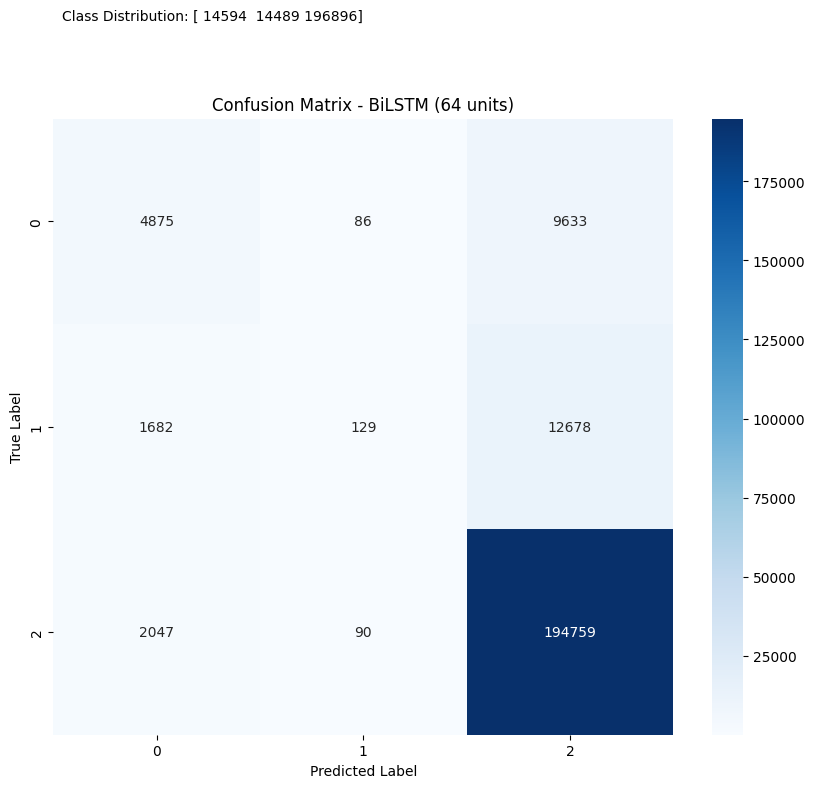

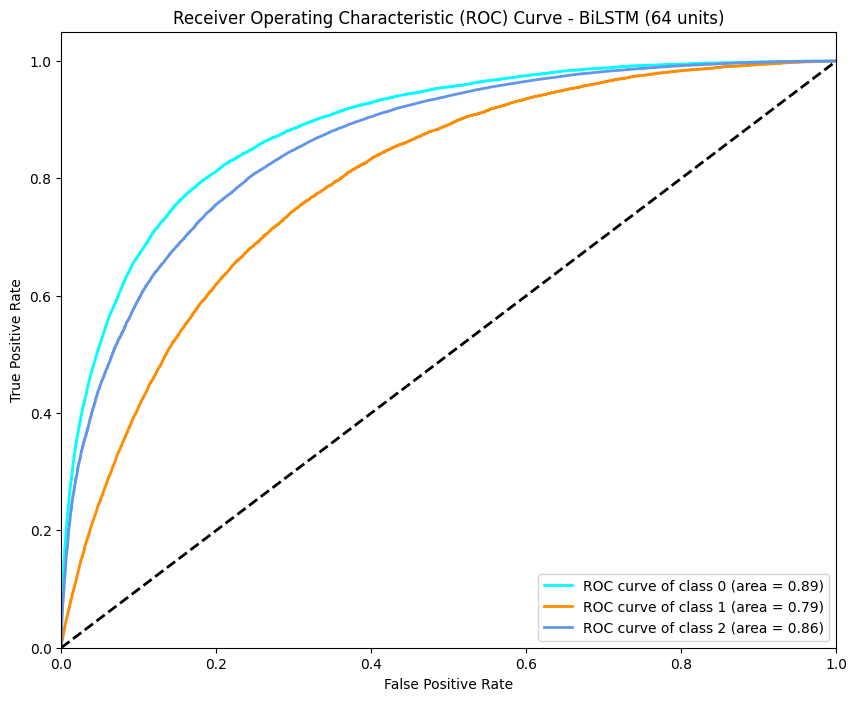


Classification Report - BiLSTM (64 units):
              precision    recall  f1-score   support

           0       0.57      0.33      0.42     14594
           1       0.42      0.01      0.02     14489
           2       0.90      0.99      0.94    196896

    accuracy                           0.88    225979
   macro avg       0.63      0.44      0.46    225979
weighted avg       0.85      0.88      0.85    225979



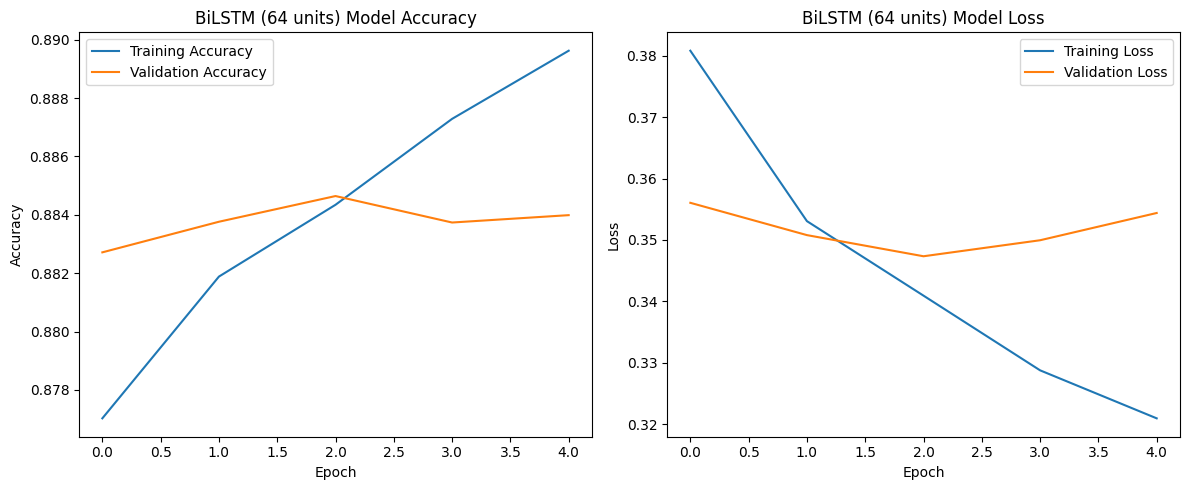


Analysis for BiLSTM (64 units):
Class distribution in true labels:
Class 0: 14594
Class 1: 14489
Class 2: 196896

Class distribution in predictions:
Class 0: 8604
Class 1: 305
Class 2: 217070


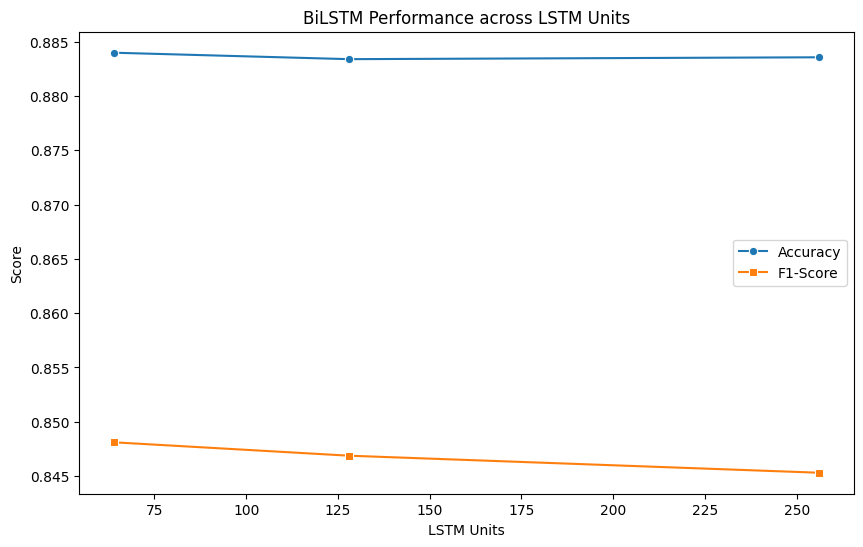

BiLSTM Variation Results:
 LSTM Units  Accuracy  F1-Score  AUC-ROC  Training Time
         64  0.883989  0.848106 0.858879    7463.196479
        128  0.883396  0.846874 0.856344    7709.478039
        256  0.883569  0.845305 0.862570    7888.717693

Best BiLSTM Configuration: LSTM Units = 64.0
Best Accuracy: 0.8840
Best F1-Score: 0.8481
Training time for best configuration: 7463.1965


In [ ]:
print(f"\nBest number of LSTM units: {best_units}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Train time for best configuration: {best_train_time}")

# Use the best model for further analysis
bilstm_model = best_model
history_bilstm = best_history

# Make predictions using the best model
y_pred_bilstm = bilstm_model.predict(X_test_bilstm_padded)
y_pred_classes_bilstm = np.argmax(y_pred_bilstm, axis=1)

# Print metrics
print_metrics(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot confusion matrix
plot_confusion_matrix(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot ROC curve
plot_roc_curve(y_test_bilstm, y_pred_bilstm, f"BiLSTM ({best_units} units)")

# Print classification report
print(f"\nClassification Report - BiLSTM ({best_units} units):")
print(classification_report(y_test_bilstm, y_pred_classes_bilstm, zero_division=0))

# Plot training history
plot_training_history(history_bilstm, f"BiLSTM ({best_units} units)")

# Analyze predictions
analyze_predictions(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Store results for later comparison
bilstm_results_dict = {
    'y_true': y_test_bilstm,
    'y_pred': y_pred_classes_bilstm,
    'y_pred_proba': y_pred_bilstm,
    'train_time': best_train_time,
    'lstm_units': best_units
}

# Compare BiLSTM variations
compare_bilstm_variations(bilstm_results)

# Hybrid CNN-BiLSTM
This section defines, trains, and evaluates the hybrid CNN-BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


Training Hybrid CNN-BiLSTM with 64 LSTM units and 100-dimensional embeddings
Epoch 1/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 495s 25ms/step - accuracy: 0.8691 - loss: 0.4176 - val_accuracy: 0.8702 - val_loss: 0.3733
Epoch 2/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 489s 25ms/step - accuracy: 0.8704 - loss: 0.3668 - val_accuracy: 0.8702 - val_loss: 0.3666
Epoch 3/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 496s 25ms/step - accuracy: 0.8726 - loss: 0.3531 - val_accuracy: 0.8799 - val_loss: 0.3655
Epoch 4/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 499s 25ms/step - accuracy: 0.8857 - loss: 0.3376 - val_accuracy: 0.8804 - val_loss: 0.3774
Epoch 5/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 489s 25ms/step - accuracy: 0.8858 - loss: 0.3189 - val_accuracy: 0.8811 - val_loss: 0.3694
Test Accuracy: 0.8811
8475/8475 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step

Hybrid CNN-BiLSTM Results:
Embedding Dimensions: 100
LSTM Units: 64
Accuracy: 0.8811
F1-Score: 0.8423
AUC-ROC: 0.8494
Training Time: 2467.71 seconds

Metrics for Hybrid CNN-BiLSTM (Embe

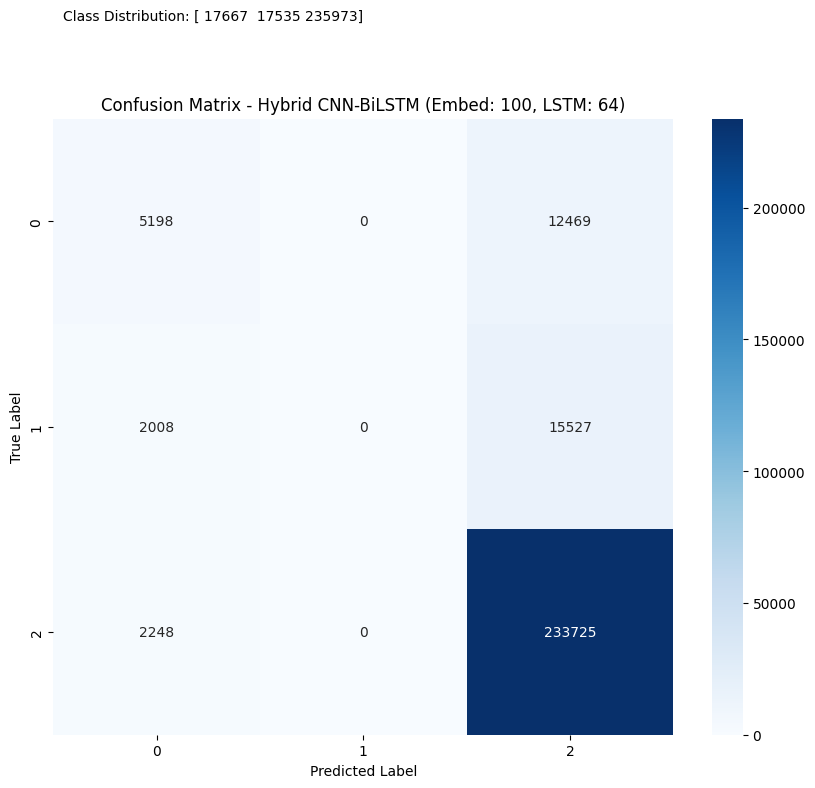

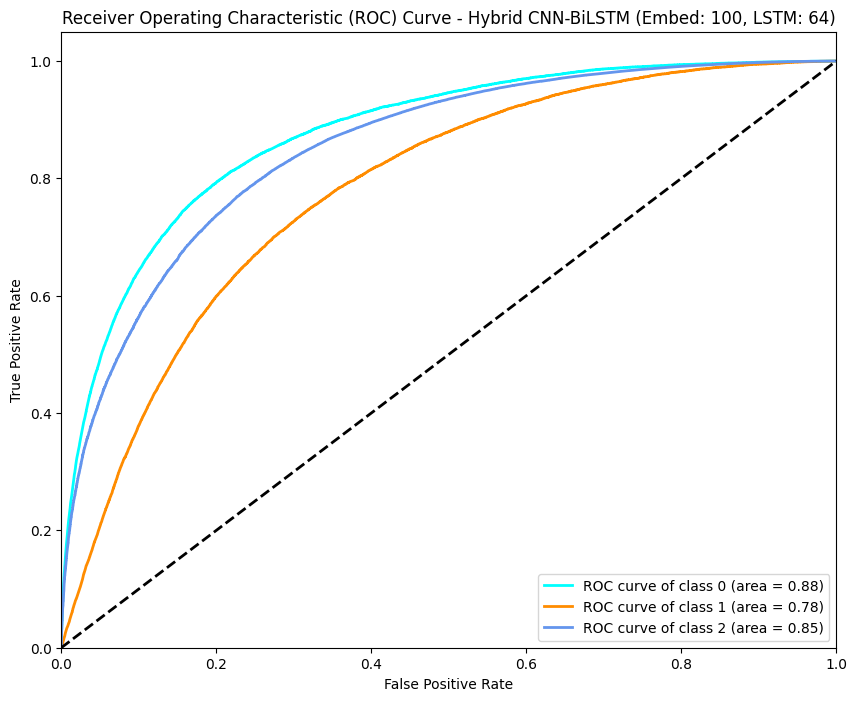


Classification Report - Hybrid CNN-BiLSTM (Embed: 100, LSTM: 64):
              precision    recall  f1-score   support

           0       0.55      0.29      0.38     17667
           1       0.00      0.00      0.00     17535
           2       0.89      0.99      0.94    235973

    accuracy                           0.88    271175
   macro avg       0.48      0.43      0.44    271175
weighted avg       0.81      0.88      0.84    271175



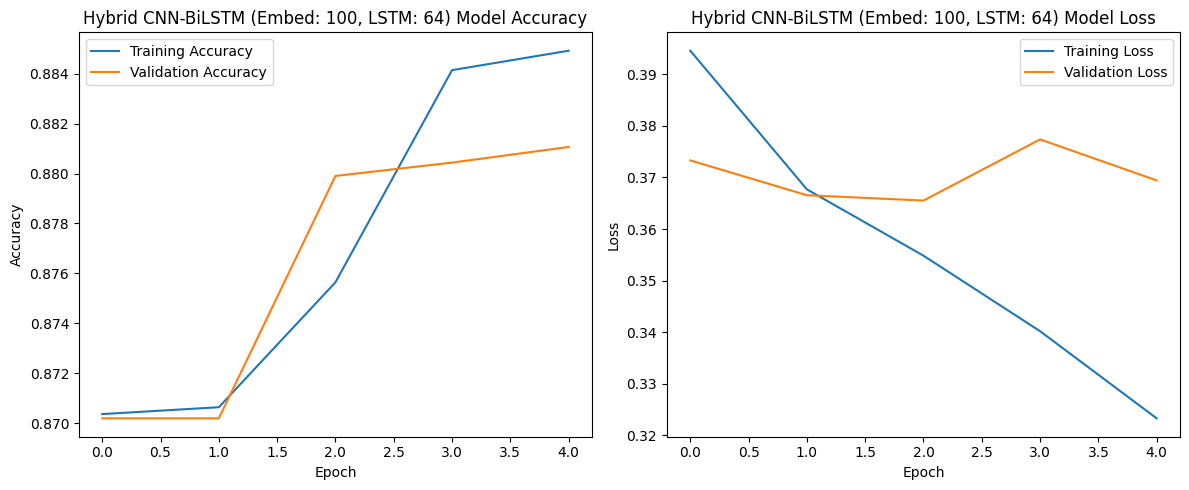


Analysis for Hybrid CNN-BiLSTM (Embed: 100, LSTM: 64):
Class distribution in true labels:
Class 0: 17667
Class 1: 17535
Class 2: 235973

Class distribution in predictions:
Class 0: 9454
Class 2: 261721

Classes not predicted by the model: {1}


In [ ]:
def create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    # First, define the CNN model
    cnn_model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        MaxPooling1D(pool_size=4, name='max_pooling1d')
    ])

    # Set the embedding weights for the CNN model
    cnn_model.get_layer('embedding').set_weights([embedding_matrix])

    # Now, add BiLSTM layers sequentially
    hybrid_model = Sequential([
        cnn_model,
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units // 2), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and measure training time
    start_time = time.time()
    history = hybrid_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    return hybrid_model, history, train_time

# Create a specific split for Hybrid model
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X, y, test_size=0.3, random_state=44)

# Pad sequences
max_length = 500
X_train_hybrid_padded = pad_sequences(X_train_hybrid, maxlen=max_length)
X_test_hybrid_padded = pad_sequences(X_test_hybrid, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_hybrid))
y_train_hybrid_cat = to_categorical(y_train_hybrid, num_classes=num_classes)
y_test_hybrid_cat = to_categorical(y_test_hybrid, num_classes=num_classes)

# Set hyperparameters
lstm_units = best_units # Best from BiLSTM
embedding_dim = best_dim  # Best from CNN
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

# Load GloVe embeddings
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

print(f"\nTraining Hybrid CNN-BiLSTM with {lstm_units} LSTM units and {embedding_dim}-dimensional embeddings")

model, history, train_time = create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units,
                                                     X_train_hybrid_padded, y_train_hybrid_cat,
                                                     X_test_hybrid_padded, y_test_hybrid_cat,
                                                     embedding_matrix)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_hybrid_padded, y_test_hybrid_cat, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate F1-Score
y_pred = model.predict(X_test_hybrid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_hybrid_cat, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test_hybrid_cat, y_pred, multi_class='ovr', average='weighted')

# Print results
print("\nHybrid CNN-BiLSTM Results:")
print(f"Embedding Dimensions: {embedding_dim}")
print(f"LSTM Units: {lstm_units}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

# Print metrics
print_metrics(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot confusion matrix
plot_confusion_matrix(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot ROC curve
plot_roc_curve(y_test_hybrid, y_pred, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Print classification report
print(f"\nClassification Report - Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units}):")
print(classification_report(y_test_hybrid, y_pred_classes, zero_division=0))

# Plot training history
plot_training_history(history, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Analyze predictions
analyze_predictions(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

hybrid_model = model
y_pred_classes_hybrid = y_pred_classes
y_pred_hybrid = y_pred

# Store results for later comparison
hybrid_results_dict = {
    'model': hybrid_model,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units,
    'train_time': train_time,
    'y_true': y_test_hybrid,
    'y_pred': y_pred_classes_hybrid,
    'y_pred_proba': y_pred_hybrid
}

In [ ]:
data = bilstm_results_dict
for key, value in data.items():
    print(f"{key}: {value}")

y_true: [2 2 2 ... 2 2 2]
y_pred: [2 2 2 ... 2 2 2]
y_pred_proba: [[0.04005042 0.07130082 0.88864875]
 [0.01711065 0.0550812  0.9278081 ]
 [0.00158216 0.00914058 0.98927724]
 ...
 [0.08962374 0.17025015 0.74012613]
 [0.00567426 0.01976112 0.9745646 ]
 [0.00161324 0.00700217 0.9913846 ]]
train_time: 7463.1964790821075
lstm_units: 64


# Comparison
This final section provides a comprehensive comparison of all four models:

1. It creates bar plots comparing the accuracy, precision, recall, and F1-score of all models.
1. It prints a table with all metrics for easy comparison.
1. It identifies the best performing model for each metric.
1. Finally, it plots ROC curves for all models on the same graph for direct comparison.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


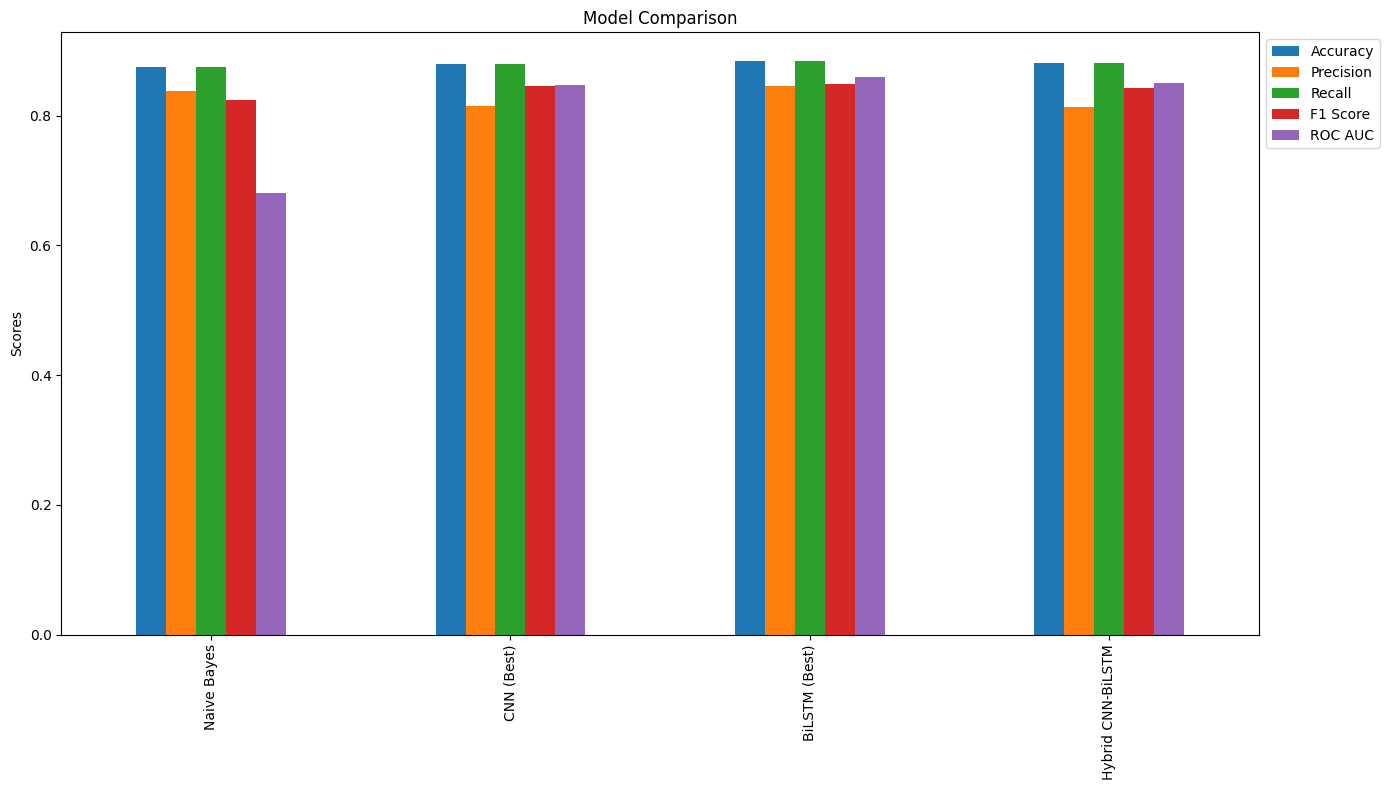


Model Comparison:
                   Accuracy  Precision    Recall  F1 Score   ROC AUC Training Time
Naive Bayes        0.875334   0.837665  0.875334  0.823462  0.679789       0.80 ms
CNN (Best)         0.879409   0.815206  0.879409  0.845315  0.846969      263.89 s
BiLSTM (Best)      0.883989   0.845457  0.883989  0.848106  0.858879     7463.20 s
Hybrid CNN-BiLSTM  0.881066   0.812925  0.881066  0.842281  0.849448     2467.71 s

Best Models:
Best Accuracy: BiLSTM (Best) (0.8839892202372787)
Best Precision: BiLSTM (Best) (0.8454572524664967)
Best Recall: BiLSTM (Best) (0.8839892202372787)
Best F1 Score: BiLSTM (Best) (0.848106160237618)
Best ROC AUC: BiLSTM (Best) (0.8588787314819084)

Model Configurations:

Naive Bayes:

CNN (Best):
  Embedding Dimension: 100

BiLSTM (Best):
  LSTM Units: 64

Hybrid CNN-BiLSTM:
  Embedding Dimension: 100
  LSTM Units: 64


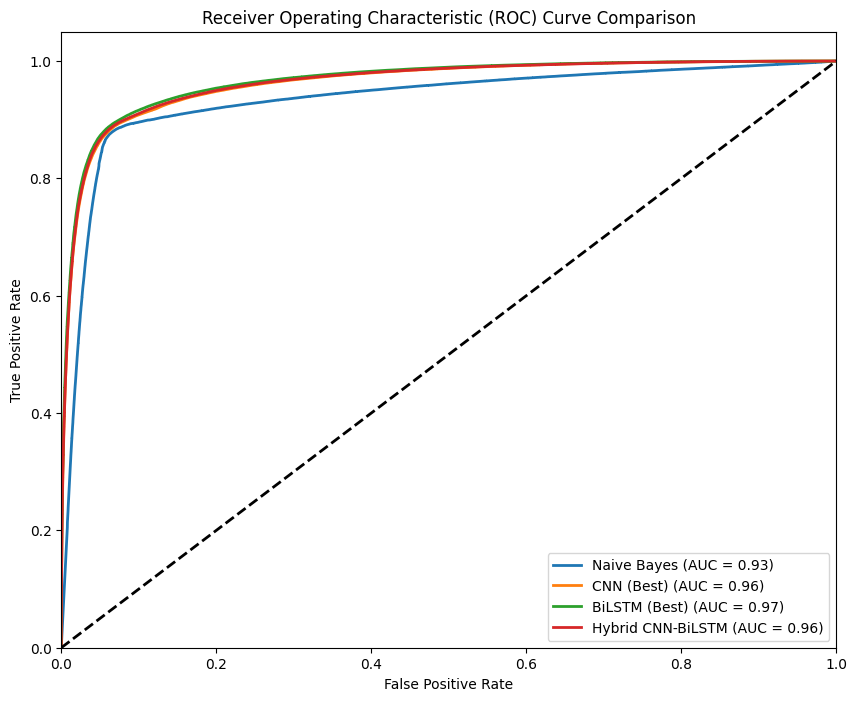

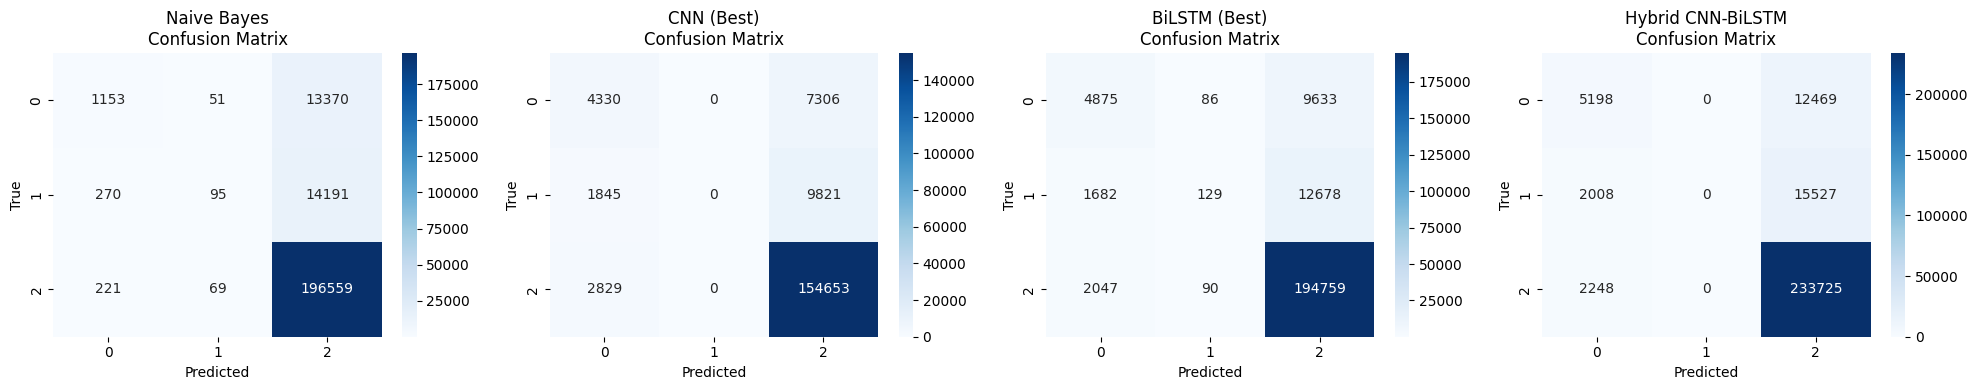

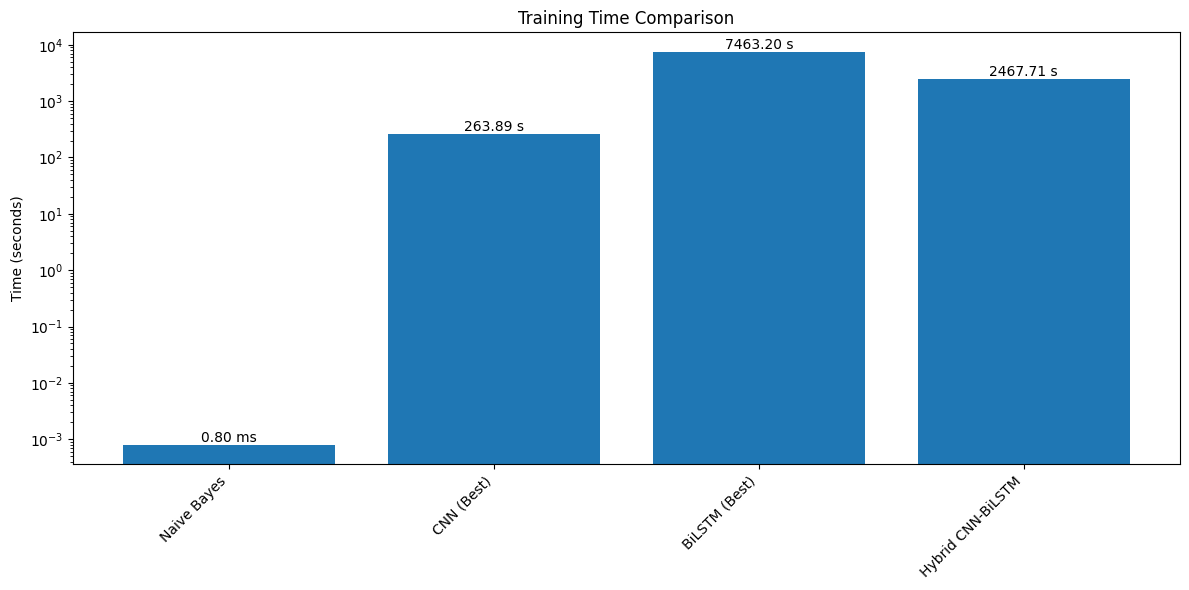

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

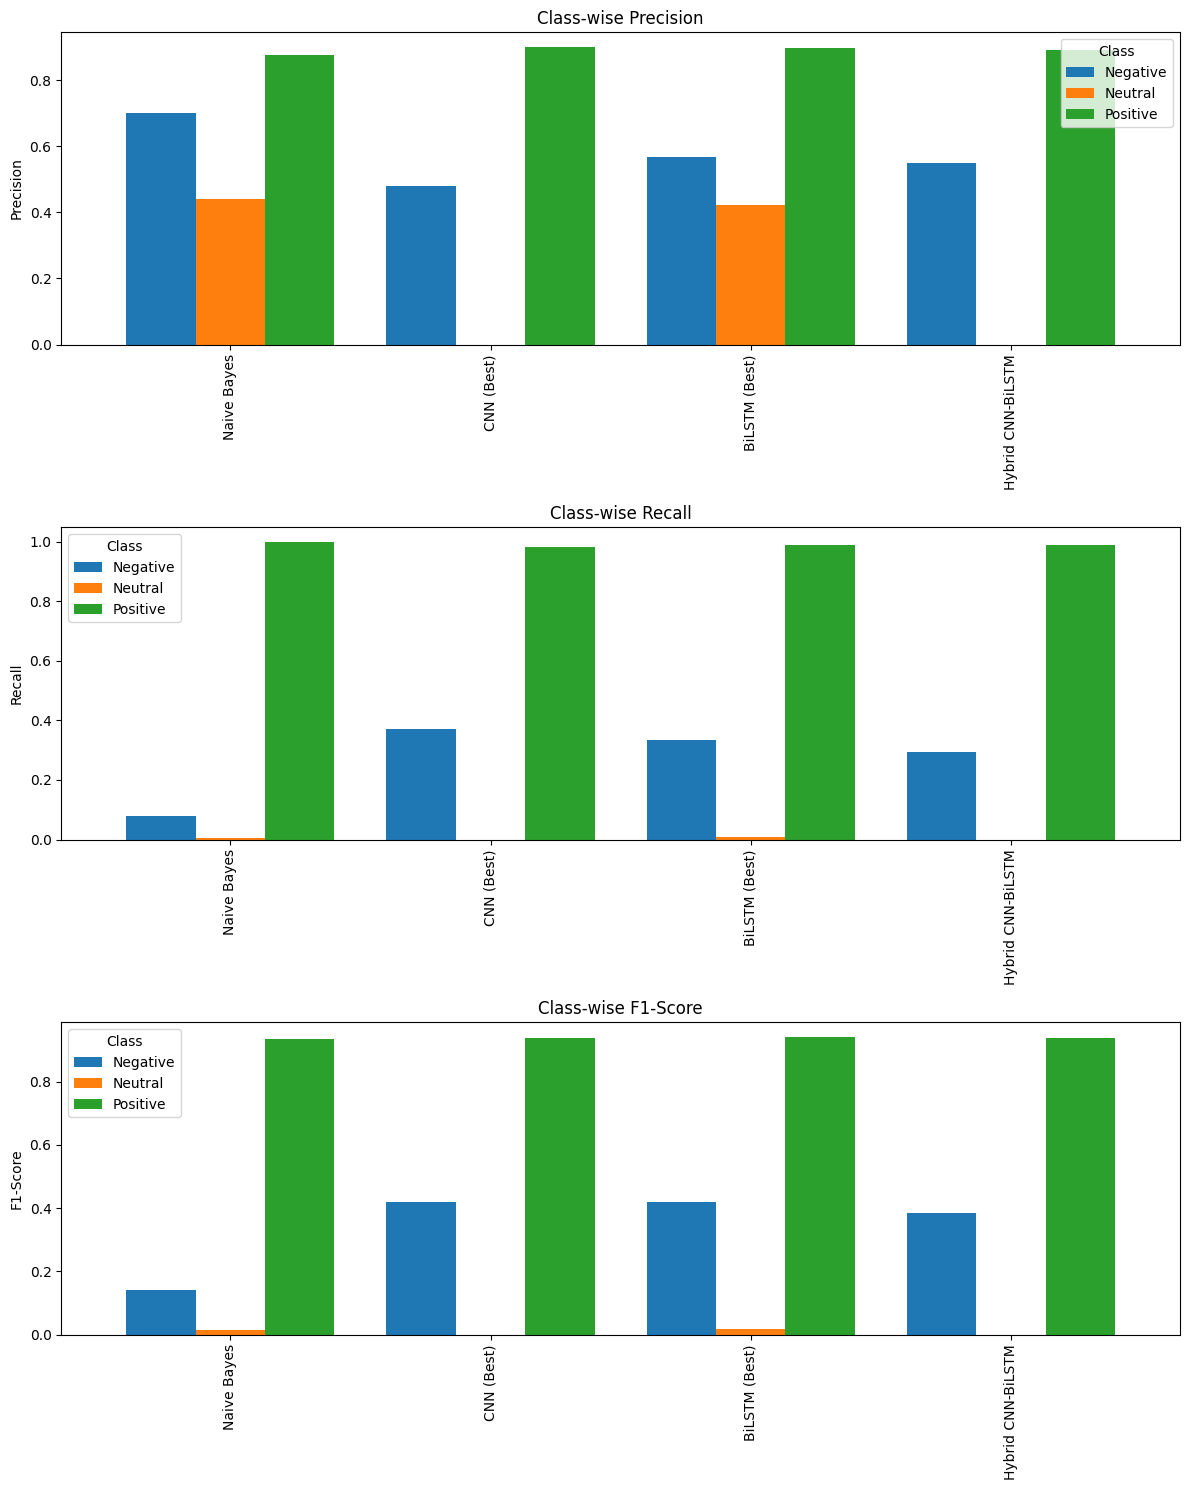

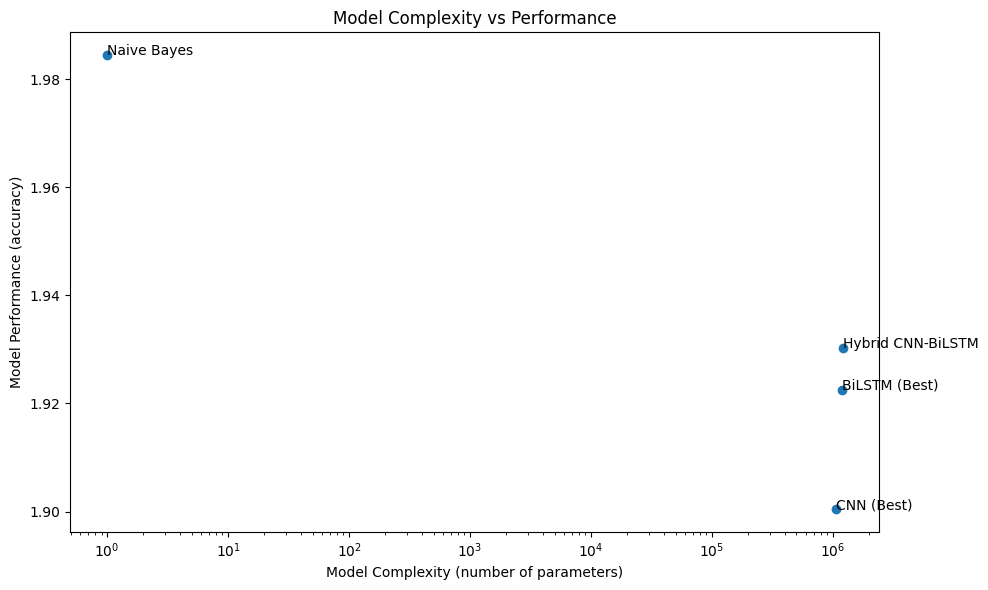


Test Set Sizes:
Naive Bayes: 225979
CNN (Best): 180784
BiLSTM (Best): 225979
Hybrid CNN-BiLSTM: 271175

Class Distribution in Test Sets:

Naive Bayes:
Class 0: 14574 (6.45%)
Class 1: 14556 (6.44%)
Class 2: 196849 (87.11%)

CNN (Best):
Class 0: 11636 (6.44%)
Class 1: 11666 (6.45%)
Class 2: 157482 (87.11%)

BiLSTM (Best):
Class 0: 14594 (6.46%)
Class 1: 14489 (6.41%)
Class 2: 196896 (87.13%)

Hybrid CNN-BiLSTM:
Class 0: 17667 (6.51%)
Class 1: 17535 (6.47%)
Class 2: 235973 (87.02%)

Model Complexity and Configuration Comparison:
Naive Bayes parameters: N/A (not applicable)
CNN parameters: 1065451 (Embedding dim: 100)
BiLSTM parameters: 1184619 (LSTM units: 64)
Hybrid parameters: 1204843 (Embedding dim: 100, LSTM units: 64)


In [ ]:
def compare_all_models(models_data):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Training Time']

    results = {}
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        y_pred_proba = data['y_pred_proba']

        # Handle multiclass ROC AUC
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        if len(classes) > 2:
            auc_score = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='weighted')
        else:
            auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])

        # Handle training time
        train_time = data.get('train_time', np.nan)
        if model_name == 'Naive Bayes':
            train_time_str = f"{train_time:.2f} ms"
        else:
            train_time_str = f"{train_time:.2f} s"

        results[model_name] = [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average='weighted'),
            recall_score(y_true, y_pred, average='weighted'),
            f1_score(y_true, y_pred, average='weighted'),
            auc_score,
            train_time_str
        ]

    # Convert results to DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)

    # Plotting performance metrics
    fig, ax = plt.subplots(figsize=(14, 8))
    results_df.iloc[:, :-1].plot(kind='bar', ax=ax)
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Print results
    print("\nModel Comparison:")
    print(results_df.to_string())

    # Determine best model for each metric
    best_models = results_df.iloc[:, :-1].idxmax()  # Exclude 'Training Time' from best model calculation
    print("\nBest Models:")
    for metric, model in best_models.items():
        print(f"Best {metric}: {model} ({results_df.loc[model, metric]})")

    # Print model configurations
    print("\nModel Configurations:")
    for model_name, data in models_data.items():
        print(f"\n{model_name}:")
        if 'embedding_dim' in data:
            print(f"  Embedding Dimension: {data['embedding_dim']}")
        if 'lstm_units' in data:
            print(f"  LSTM Units: {data['lstm_units']}")

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred_proba = data['y_pred_proba']

        # Binarize the output
        y_test_bin = label_binarize(y_true, classes=np.unique(y_true))
        n_classes = y_test_bin.shape[1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})',
                 linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

    return results_df

def plot_confusion_matrices(models_data):
    n_models = len(models_data)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    for ax, (model_name, data) in zip(axes, models_data.items()):
        cm = confusion_matrix(data['y_true'], data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{model_name}\nConfusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_training_times(models_data):
    model_names = list(models_data.keys())
    times = []
    for model, data in models_data.items():
        if model == 'Naive Bayes':
            times.append(data['train_time'] / 1000)  # Convert milliseconds to seconds
        else:
            times.append(data['train_time'])

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, times)
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.yscale('log')  # Using log scale due to large differences
    plt.xticks(rotation=45, ha='right')

    # Annotate bars with time and units
    for bar in bars:
        height = bar.get_height()
        if bar.get_x() + bar.get_width() / 2 < 0.5:  # Naive Bayes bar
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height*1000:.2f} ms',
                     ha='center', va='bottom', rotation=0)
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f} s',
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

def plot_class_performance(models_data):
    class_names = ['Negative', 'Neutral', 'Positive']  # Adjust based on your classes
    metrics = ['Precision', 'Recall', 'F1-Score']

    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)))
    for i, metric in enumerate(metrics):
        data = []
        for model_name, model_data in models_data.items():
            scores = precision_recall_fscore_support(model_data['y_true'], model_data['y_pred'], average=None)[i]
            data.append(scores)

        df = pd.DataFrame(data, columns=class_names, index=models_data.keys())
        df.plot(kind='bar', ax=axes[i], width=0.8)
        axes[i].set_title(f'Class-wise {metric}')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Class')

    plt.tight_layout()
    plt.show()

def plot_complexity_vs_performance(models_data):
    complexities = {
        'Naive Bayes': 1,  # placeholder value
        'CNN (Best)': cnn_model.count_params(),
        'BiLSTM (Best)': bilstm_model.count_params(),
        'Hybrid CNN-BiLSTM': hybrid_model.count_params()
    }
    performances = {model: data['y_pred'].mean() for model, data in models_data.items()}

    plt.figure(figsize=(10, 6))
    plt.scatter(complexities.values(), performances.values())
    for model, complexity in complexities.items():
        plt.annotate(model, (complexity, performances[model]))
    plt.xscale('log')
    plt.xlabel('Model Complexity (number of parameters)')
    plt.ylabel('Model Performance (accuracy)')
    plt.title('Model Complexity vs Performance')
    plt.tight_layout()
    plt.show()

# Prepare data for comparison
models_data = {
    'Naive Bayes': nb_results_dict,
    'CNN (Best)': cnn_results_dict,
    'BiLSTM (Best)': bilstm_results_dict,
    'Hybrid CNN-BiLSTM': hybrid_results_dict
}

# Run comparison
results_df = compare_all_models(models_data)
plot_confusion_matrices(models_data)
plot_training_times(models_data)
plot_class_performance(models_data)
plot_complexity_vs_performance(models_data)

# Additional analysis
print("\nTest Set Sizes:")
for model, data in models_data.items():
    print(f"{model}: {len(data['y_true'])}")

print("\nClass Distribution in Test Sets:")
for model, data in models_data.items():
    y_test = data['y_true']
    unique, counts = np.unique(y_test, return_counts=True)
    print(f"\n{model}:")
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} ({count/len(y_test):.2%})")



# Model complexity and configuration comparison
print("\nModel Complexity and Configuration Comparison:")
print(f"Naive Bayes parameters: N/A (not applicable)")
print(f"CNN parameters: {cnn_model.count_params()} (Embedding dim: {models_data['CNN (Best)']['embedding_dim']})")
print(f"BiLSTM parameters: {bilstm_model.count_params()} (LSTM units: {models_data['BiLSTM (Best)']['lstm_units']})")
print(f"Hybrid parameters: {hybrid_model.count_params()} (Embedding dim: {models_data['Hybrid CNN-BiLSTM']['embedding_dim']}, LSTM units: {models_data['Hybrid CNN-BiLSTM']['lstm_units']})")